In [1]:
from pathlib import Path

import tifffile
import numpy as np
import matplotlib.pyplot as plt
from careamics_portfolio import PortfolioManager

from careamics.lightning.dataset_ng.lightning_module import UNetModule
from careamics.lightning.dataset_ng.data_module import CareamicsDataModule
from careamics.config import create_care_configuration
from careamics.dataset_ng.legacy_interoperability import imageregions_to_tileinfos
from careamics.prediction_utils import convert_outputs

In [ ]:
# Set seed for reproducibility
from pytorch_lightning import seed_everything
seed_everything(42)

### Load data and set paths to it

In [3]:
# instantiate data portfolio manager and download the data
root_path = Path("./data")

portfolio = PortfolioManager()
download = portfolio.denoising.CARE_U2OS.download(root_path)

root_path = root_path / "denoising-CARE_U2OS.unzip" / "data" / "U2OS"
train_path = root_path / "train" / "low"
target_path = root_path / "train" / "GT"
test_path = root_path / "test" / "low"
test_target_path = root_path / "test" / "GT"

### Create config

In [5]:
# Currently the runtime stats are not implemented, setting manually
train_files = sorted(train_path.glob('*.tif'))
train_target_files = sorted(target_path.glob('*.tif'))

input_mean = np.mean([tifffile.imread(image).mean() for image in train_files])
input_std = np.mean([tifffile.imread(image).std() for image in train_files])

target_mean = np.mean([tifffile.imread(image).mean() for image in train_target_files])
target_std = np.mean([tifffile.imread(image).std() for image in train_target_files])

config = create_care_configuration(
    experiment_name="care_U20S",
    data_type="tiff",
    axes="YX",
    patch_size=(128, 128),
    batch_size=32,
    num_epochs=50
)

config.data_config.set_means_and_stds(
    [input_mean], [input_std], [target_mean], [target_std]
)

### Create Lightning datamodule and model

In [6]:
train_data_module = CareamicsDataModule(
    data_config=config.data_config,
    train_data=train_path,
    train_data_target=target_path,
    val_data=test_path,
    val_data_target=test_target_path    
)

model = UNetModule(config.algorithm_config)

### Manually initialize the datamodule and visualize single train and val batches

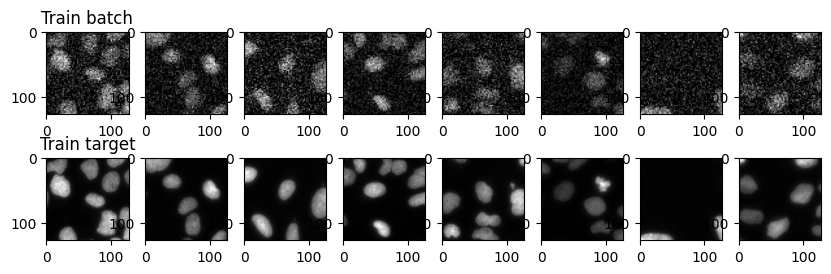

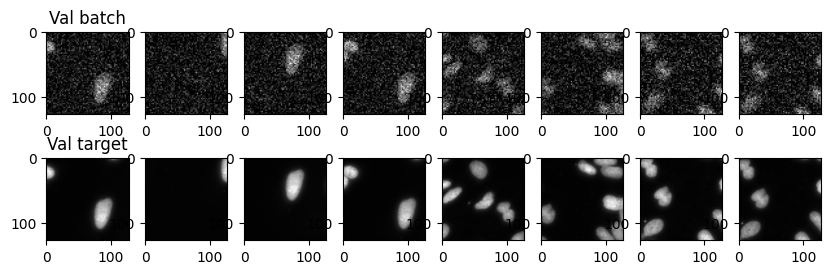

In [7]:
train_data_module.setup('fit')
train_data_module.setup('validate')

train_batch = next(iter(train_data_module.train_dataloader()))
val_batch = next(iter(train_data_module.val_dataloader()))

fig, ax = plt.subplots(2, 8, figsize=(10, 3))

ax[0][0].set_title("Train batch")
ax[1][0].set_title("Train target")
for i in range(8):
    ax[0][i].imshow(train_batch[0].data[i][0].numpy(), cmap="gray")
    ax[1][i].imshow(train_batch[1].data[i][0].numpy(), cmap="gray")


fig, ax = plt.subplots(2, 8, figsize=(10, 3))
ax[0][0].set_title("Val batch")
ax[1][0].set_title("Val target")
for i in range(8):
    ax[0][i].imshow(val_batch[0].data[i][0].numpy(), cmap="gray")
    ax[1][i].imshow(val_batch[1].data[i][0].numpy(), cmap="gray")

### Train the model

In [ ]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger

root = Path("care_baseline")
callbacks = [
    ModelCheckpoint(
        dirpath=root / "checkpoints",
        filename="care_baseline",
        save_last=True,
        monitor="val_loss",
        mode="min",
    )
]

wandb_logger = WandbLogger(project="care-U2OS", name="new-dataset")

trainer = Trainer(
    max_epochs=50, 
    default_root_dir=root,
    callbacks=callbacks,
    logger=wandb_logger
)
trainer.fit(model, datamodule=train_data_module)

### Create an inference config and datamodule

In [9]:
from careamics.config.inference_model import InferenceConfig

config = InferenceConfig(
    model_config=config,
    data_type="tiff",
    tile_size=(128, 128),
    tile_overlap=(32, 32),
    axes="YX",
    batch_size=1,
    image_means=train_data_module.train_dataset.input_stats.means,
    image_stds=train_data_module.train_dataset.input_stats.stds
)

inf_data_module = CareamicsDataModule(
    data_config=config,
    pred_data=test_path,
    pred_data_target=test_target_path
)

### Convert outputs to the legacy format and stitch the tiles

In [ ]:
predictions = trainer.predict(model, datamodule=inf_data_module)
tile_infos = imageregions_to_tileinfos(predictions)
prediction = convert_outputs(tile_infos, tiled=True)

### Visualize predictions and count metrics

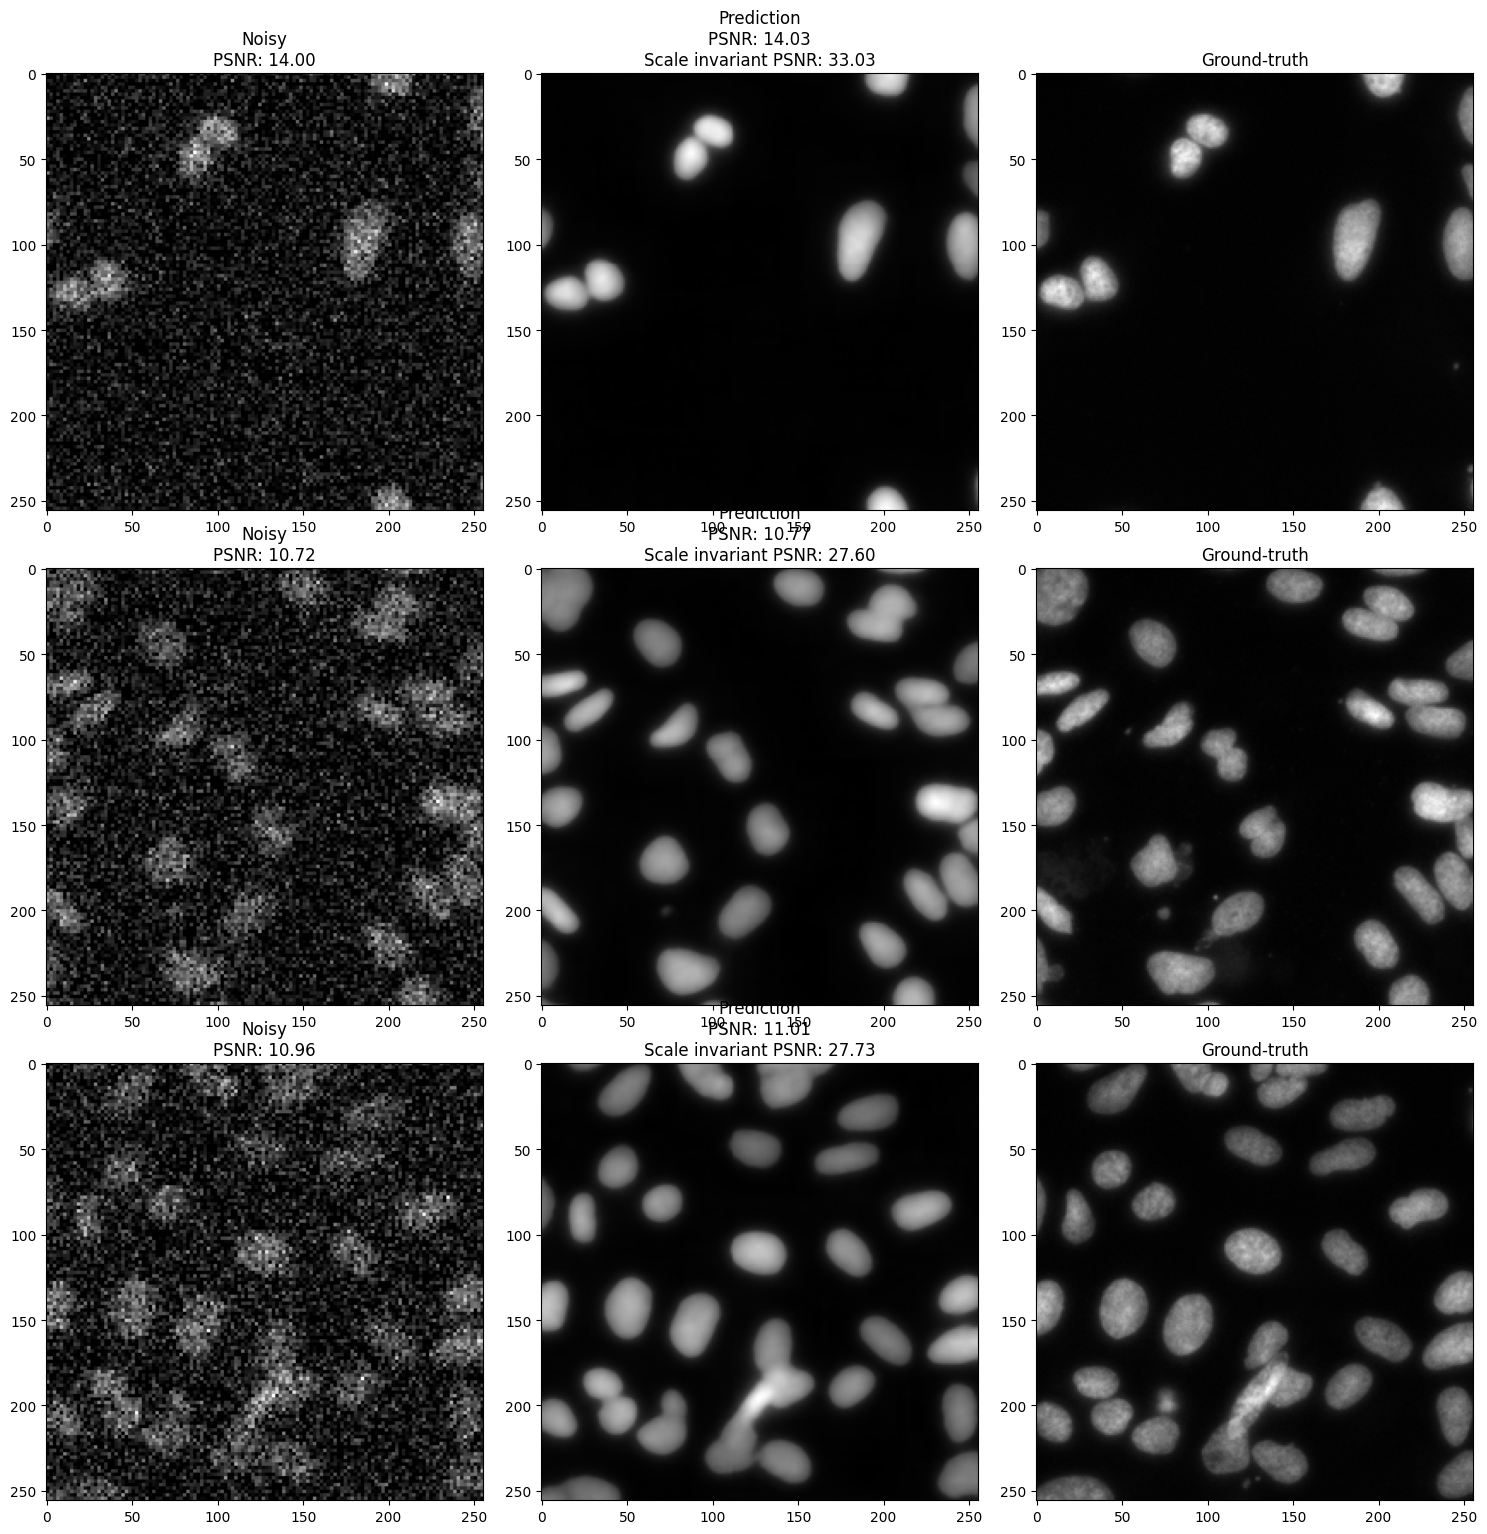

In [11]:
from careamics.utils.metrics import psnr, scale_invariant_psnr

# Show two images
noises = [tifffile.imread(f) for f in sorted(test_path.glob("*.tif"))]
gts = [tifffile.imread(f) for f in sorted(test_target_path.glob("*.tif"))]

# images to show
images = [0, 1, 2]

fig, ax = plt.subplots(3, 3, figsize=(15, 15))
fig.tight_layout()

for i in range(3):
    pred_image = prediction[images[i]].squeeze()
    psnr_noisy = psnr(gts[images[i]], noises[images[i]], data_range=gts[images[i]].max() - gts[images[i]].min())
    psnr_result = psnr(gts[images[i]], pred_image, data_range=gts[images[i]].max() - gts[images[i]].min())

    scale_invariant_psnr_result = scale_invariant_psnr(gts[images[i]], pred_image)

    ax[i, 0].imshow(noises[images[i]], cmap="gray")
    ax[i, 0].title.set_text(f"Noisy\nPSNR: {psnr_noisy:.2f}")

    ax[i, 1].imshow(pred_image, cmap="gray")
    ax[i, 1].title.set_text(f"Prediction\nPSNR: {psnr_result:.2f}\nScale invariant PSNR: {scale_invariant_psnr_result:.2f}")

    ax[i, 2].imshow(gts[images[i]], cmap="gray")
    ax[i, 2].title.set_text("Ground-truth")


In [12]:
psnrs = np.zeros((len(prediction), 1))
scale_invariant_psnrs = np.zeros((len(prediction), 1))

for i, (pred, gt) in enumerate(zip(prediction, gts)):
    psnrs[i] = psnr(gt, pred.squeeze(), data_range=gt.max() - gt.min())
    scale_invariant_psnrs[i] = scale_invariant_psnr(gt, pred.squeeze())

print(f"PSNR: {psnrs.mean():.2f} +/- {psnrs.std():.2f}")
print(f"Scale invariant PSNR: {scale_invariant_psnrs.mean():.2f} +/- {scale_invariant_psnrs.std():.2f}")
print("Target PSNR: 31.53 +/- 3.71")

PSNR: 13.52 +/- 4.59
Scale invariant PSNR: 31.58 +/- 3.72
Target PSNR: 31.53 +/- 3.71
